In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

In [2]:
def custom_fill_na(df):
    # Iterate over each column in the DataFrame
    for column in df.columns:
        # Iterate over each row in the column
        for i in range(len(df)):
            # If the value is missing (NaN)
            if pd.isna(df.iloc[i, df.columns.get_loc(column)]):
                # Get the value above and below the current cell
                value_above = df.iloc[i - 1, df.columns.get_loc(column)] if i > 0 else np.nan
                value_below = df.iloc[i + 1, df.columns.get_loc(column)] if i < len(df) - 1 else np.nan

                # Replace missing neighbor with the other neighbor if available
                if pd.isna(value_above):
                    value_above = value_below
                if pd.isna(value_below):
                    value_below = value_above

                # Calculate the average of the above and below values, if both are available
                if pd.notna(value_above) and pd.notna(value_below):
                    new_value = (value_above + value_below) / 2
                else:
                    # If only one neighbor is available, use that
                    new_value = value_above if pd.notna(value_above) else value_below

                # Replace the NaN value with the new calculated value
                df.iloc[i, df.columns.get_loc(column)] = new_value
    
    return df

In [3]:
# Load the data (using only teh 1200mg/L dataset)
data = pd.read_excel('Batch 1200mgl.xlsx')
#data = pd.read_excel('data.xlsx')
data.head()
data.shape

(31, 4)

In [4]:
data = custom_fill_na(data)
t_exp = np.array(data['time'])
data_exp = np.array(data[['Nitrate', 'Biomass', 'pc']])

In [5]:
# Split data into training and testing sets
train_size = 24
t_train = t_exp[:train_size]
data_train = data_exp[:train_size]
t_test = t_exp[train_size:]
data_test = data_exp[train_size:]

In [6]:
# Convert training data to PyTorch tensors
#t_train_tensor = torch.tensor(t_train, dtype=torch.float32, requires_grad=True).reshape(-1, 1)
t_train_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
data_train_tensor = torch.tensor(data_train, dtype=torch.float32).reshape(-1, 3)

In [7]:
# Define the system of ODEs for kinetics
def kinetics_model(y, t, mu_max, K_s, Y, k):
    N, X, pc = y
    dNdt = -1/Y * (mu_max * N / (K_s + N)) * X
    dXdt = mu_max * N / (K_s + N) * X
    dpcdt = k * X
    return [dNdt, dXdt, dpcdt]

In [8]:
# Define the PINN model with physics constraints
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(1, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 3)
        
        # Define trainable ODE parameters
        self.mu_max = nn.Parameter(torch.tensor(1.0))
        self.K_s = nn.Parameter(torch.tensor(1.0))
        self.Y = nn.Parameter(torch.tensor(1.0))
        self.k = nn.Parameter(torch.tensor(1.0))

    def forward(self, t):
        x = torch.relu(self.fc1(t))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [9]:
# Define the ANN model without physics constraints
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(1, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 3)

    def forward(self, t):
        x = torch.relu(self.fc1(t))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [10]:
# Define the physics-based loss function for PINN
def physics_loss(model, t):
    t = t.clone().detach().requires_grad_(True)  # Ensure t has requires_grad=True and is a leaf tensor
    y_pred = model(t)
    N_pred, X_pred, pc_pred = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]
    
    # Compute derivatives
    dNdt_pred = torch.autograd.grad(N_pred, t, grad_outputs=torch.ones_like(N_pred), create_graph=True, retain_graph=True)[0]
    dXdt_pred = torch.autograd.grad(X_pred, t, grad_outputs=torch.ones_like(X_pred), create_graph=True, retain_graph=True)[0]
    dpcdt_pred = torch.autograd.grad(pc_pred, t, grad_outputs=torch.ones_like(pc_pred), create_graph=True, retain_graph=True)[0]
    
    # Physics equations
    eq1 = dNdt_pred + (1/model.Y) * (model.mu_max * N_pred / (model.K_s + N_pred)) * X_pred
    eq2 = dXdt_pred - model.mu_max * N_pred / (model.K_s + N_pred) * X_pred
    eq3 = dpcdt_pred - model.k * X_pred
    
    return torch.mean(eq1**2) + torch.mean(eq2**2) + torch.mean(eq3**2)

In [11]:
# Define the threshold-based reward function for RL
fixed_threshold = 0.1
data_weight = 5.0  # Weight to prioritize data matching over physics constraints

def compute_reward_with_threshold(model, t, true_data, threshold=fixed_threshold, is_pinn=True):
    t = t.clone().detach().requires_grad_(True)  # Ensure t has requires_grad=True
    predictions = model(t)
    data_loss = torch.mean((predictions - true_data)**2)
    
    # For PINN, include weighted data loss and physics deviation in the reward
    if is_pinn:
        # Compute physics deviation
        physics_deviation = physics_loss(model, t)
        
        # Apply penalty if physics deviation exceeds threshold
        penalty = (physics_deviation - threshold) * 10 if physics_deviation > threshold else 0
        
        # Weighted reward to prioritize data loss
        reward = -(data_weight * data_loss + physics_deviation + penalty).item()
    else:
        # ANN does not have physics constraints, so no physics deviation penalty
        reward = -data_loss.item()
    
    return reward

In [12]:
# Hyperparameters for reinforcement learning
num_episodes = 65000
learning_rate = 0.001

In [13]:
# Initialize models, optimizers, and lists for rewards
pinn_model = PINN()
ann_model = ANN()
pinn_optimizer = optim.Adam(pinn_model.parameters(), lr=learning_rate)
ann_optimizer = optim.Adam(ann_model.parameters(), lr=learning_rate)
rewards_pinn = []
rewards_ann = []

Episode 1/65000: PINN Reward = -5842622.5, ANN Reward = -1166077.5
Episode 1001/65000: PINN Reward = -139031.671875, ANN Reward = -61750.953125
Episode 2001/65000: PINN Reward = -71092.515625, ANN Reward = -10090.916015625
Episode 3001/65000: PINN Reward = -69592.6171875, ANN Reward = -9989.2255859375
Episode 4001/65000: PINN Reward = -68034.0859375, ANN Reward = -9850.498046875
Episode 5001/65000: PINN Reward = -66817.7421875, ANN Reward = -9668.6435546875
Episode 6001/65000: PINN Reward = -65411.703125, ANN Reward = -9401.4306640625
Episode 7001/65000: PINN Reward = -65171.09375, ANN Reward = -9059.3154296875
Episode 8001/65000: PINN Reward = -63810.875, ANN Reward = -8754.3046875
Episode 9001/65000: PINN Reward = -59436.93359375, ANN Reward = -8288.17578125
Episode 10001/65000: PINN Reward = -54180.8125, ANN Reward = -7443.51904296875
Episode 11001/65000: PINN Reward = -53227.2890625, ANN Reward = -6214.76025390625
Episode 12001/65000: PINN Reward = -52440.078125, ANN Reward = -4892

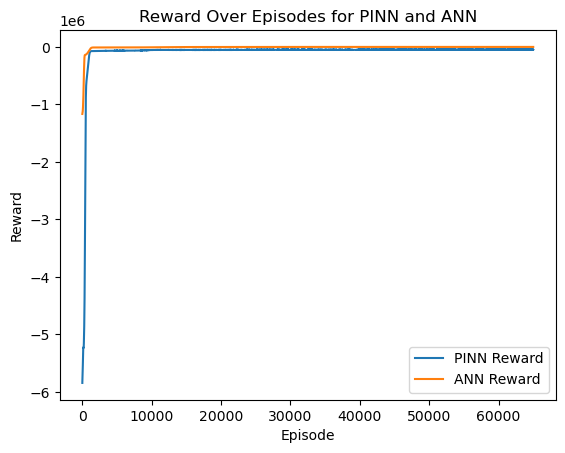

In [14]:
# Training loop for PINN and ANN using reinforcement learning approach
for episode in range(num_episodes):
    # Re-create t_train_tensor with requires_grad=True each time
    t_train_tensor = torch.tensor(t_train, dtype=torch.float32, requires_grad=True).view(-1, 1)
    
    # PINN model training with physics loss
    reward_pinn = compute_reward_with_threshold(pinn_model, t_train_tensor, data_train_tensor, threshold=fixed_threshold, is_pinn=True)
    rewards_pinn.append(reward_pinn)
    
    pinn_model.train()
    pinn_optimizer.zero_grad()
    data_pred_pinn = pinn_model(t_train_tensor)
    data_loss_pinn = torch.mean((data_pred_pinn - data_train_tensor)**2)
    p_loss_pinn = physics_loss(pinn_model, t_train_tensor)
    total_loss_pinn = data_loss_pinn + p_loss_pinn - reward_pinn
    total_loss_pinn.backward()
    pinn_optimizer.step()

    # ANN model training without physics loss
    reward_ann = compute_reward_with_threshold(ann_model, t_train_tensor, data_train_tensor, threshold=fixed_threshold, is_pinn=False)
    rewards_ann.append(reward_ann)
    
    ann_model.train()
    ann_optimizer.zero_grad()
    data_pred_ann = ann_model(t_train_tensor)
    total_loss_ann = torch.mean((data_pred_ann - data_train_tensor)**2) - reward_ann
    total_loss_ann.backward()
    ann_optimizer.step()
    
    if episode % 1000 == 0:
        print(f"Episode {episode + 1}/{num_episodes}: PINN Reward = {reward_pinn}, ANN Reward = {reward_ann}")

# Plot reward over episodes for both models
plt.plot(rewards_pinn, label='PINN Reward')
plt.plot(rewards_ann, label='ANN Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward Over Episodes for PINN and ANN')
plt.legend()
plt.show()

In [15]:
# Convert test data to PyTorch tensor for evaluation
t_test_tensor = torch.tensor(t_test, dtype=torch.float32, requires_grad=True).reshape(-1, 1)

In [16]:
# Predictions on test data from both models
with torch.no_grad():
    predictions_pinn_test = pinn_model(t_test_tensor).detach().numpy()
    predictions_ann_test = ann_model(t_test_tensor).detach().numpy()

In [17]:
# Define function to calculate evaluation metrics
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2

# Calculate metrics for each variable and each model on the test set
metrics_test = {"PINN": {}, "ANN": {}}
for i, label in enumerate(["Nitrate", "Biomass", "C-PC"]):
    # Test data and predictions for each variable
    y_true_test = data_test[:, i]
    y_pred_pinn_test = predictions_pinn_test[:, i]
    y_pred_ann_test = predictions_ann_test[:, i]
    
    # Compute metrics for PINN
    mse_pinn, rmse_pinn, mae_pinn, r2_pinn = calculate_metrics(y_true_test, y_pred_pinn_test)
    metrics_test["PINN"][label] = {"MSE": mse_pinn, "RMSE": rmse_pinn, "MAE": mae_pinn, "R2": r2_pinn}
    
    # Compute metrics for ANN
    mse_ann, rmse_ann, mae_ann, r2_ann = calculate_metrics(y_true_test, y_pred_ann_test)
    metrics_test["ANN"][label] = {"MSE": mse_ann, "RMSE": rmse_ann, "MAE": mae_ann, "R2": r2_ann}

# Display the test set metrics
for model_name, model_metrics in metrics_test.items():
    print(f"\n{model_name} Model Performance on Test Set:")
    for variable, variable_metrics in model_metrics.items():
        print(f"{variable}:")
        for metric_name, metric_value in variable_metrics.items():
            print(f"  {metric_name}: {metric_value:.4f}")


PINN Model Performance on Test Set:
Nitrate:
  MSE: 24345.6766
  RMSE: 156.0310
  MAE: 148.4222
  R2: -17.2457
Biomass:
  MSE: 15032.9857
  RMSE: 122.6091
  MAE: 85.6139
  R2: 0.8053
C-PC:
  MSE: 1390.1113
  RMSE: 37.2842
  MAE: 29.3825
  R2: -10.2409

ANN Model Performance on Test Set:
Nitrate:
  MSE: 563382.0055
  RMSE: 750.5878
  MAE: 672.2048
  R2: -421.2224
Biomass:
  MSE: 65660.7122
  RMSE: 256.2435
  MAE: 199.9790
  R2: 0.1497
C-PC:
  MSE: 8119.6563
  RMSE: 90.1091
  MAE: 72.0031
  R2: -64.6580


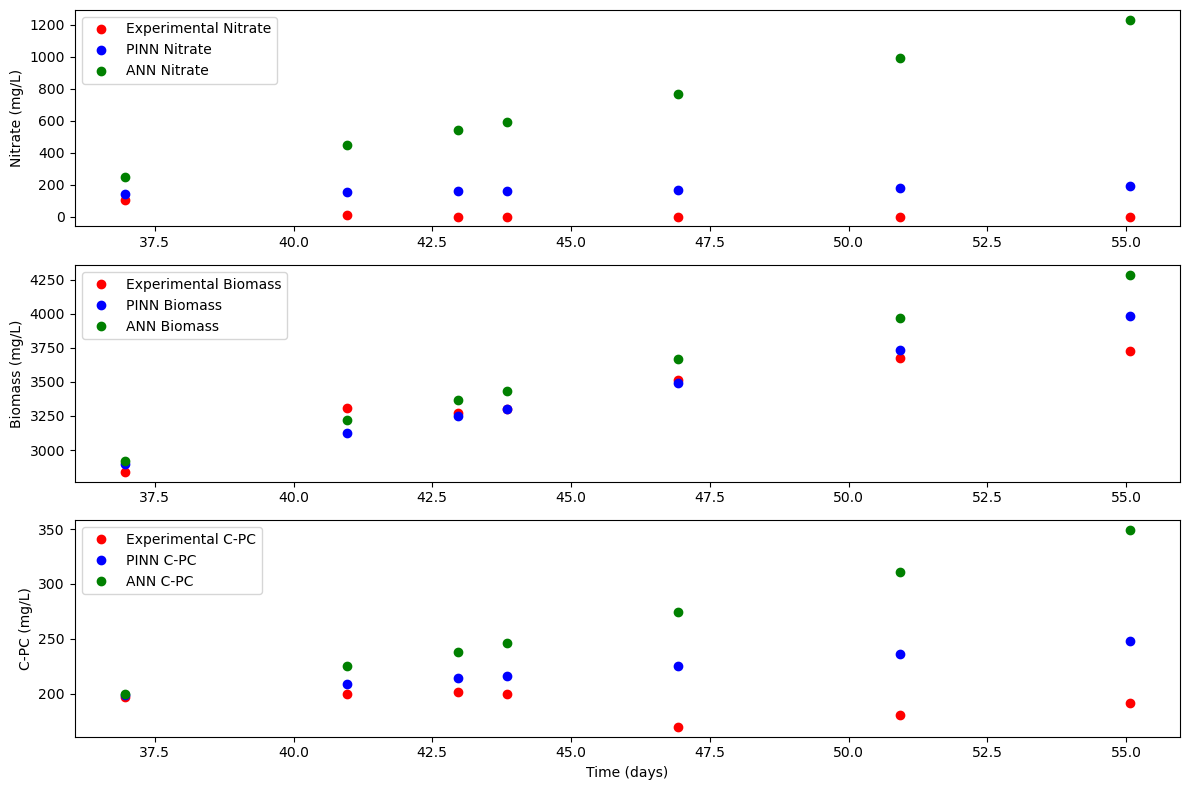

In [18]:
# Plot experimental vs predicted data for test set
plt.figure(figsize=(12, 8))

# Plot Nitrate
plt.subplot(3, 1, 1)
plt.plot(t_test, data_test[:, 0], 'ro', label='Experimental Nitrate')
plt.plot(t_test, predictions_pinn_test[:, 0], 'bo', label='PINN Nitrate')
plt.plot(t_test, predictions_ann_test[:, 0], 'go', label='ANN Nitrate')
plt.ylabel('Nitrate (mg/L)')
plt.legend()

# Plot Biomass
plt.subplot(3, 1, 2)
plt.plot(t_test, data_test[:, 1], 'ro', label='Experimental Biomass')
plt.plot(t_test, predictions_pinn_test[:, 1], 'bo', label='PINN Biomass')
plt.plot(t_test, predictions_ann_test[:, 1], 'go', label='ANN Biomass')
plt.ylabel('Biomass (mg/L)')
plt.legend()

# Plot C-PC
plt.subplot(3, 1, 3)
plt.plot(t_test, data_test[:, 2], 'ro', label='Experimental C-PC')
plt.plot(t_test, predictions_pinn_test[:, 2], 'bo', label='PINN C-PC')
plt.plot(t_test, predictions_ann_test[:, 2], 'go', label='ANN C-PC')
plt.xlabel('Time (days)')
plt.ylabel('C-PC (mg/L)')
plt.legend()

plt.tight_layout()
plt.show()

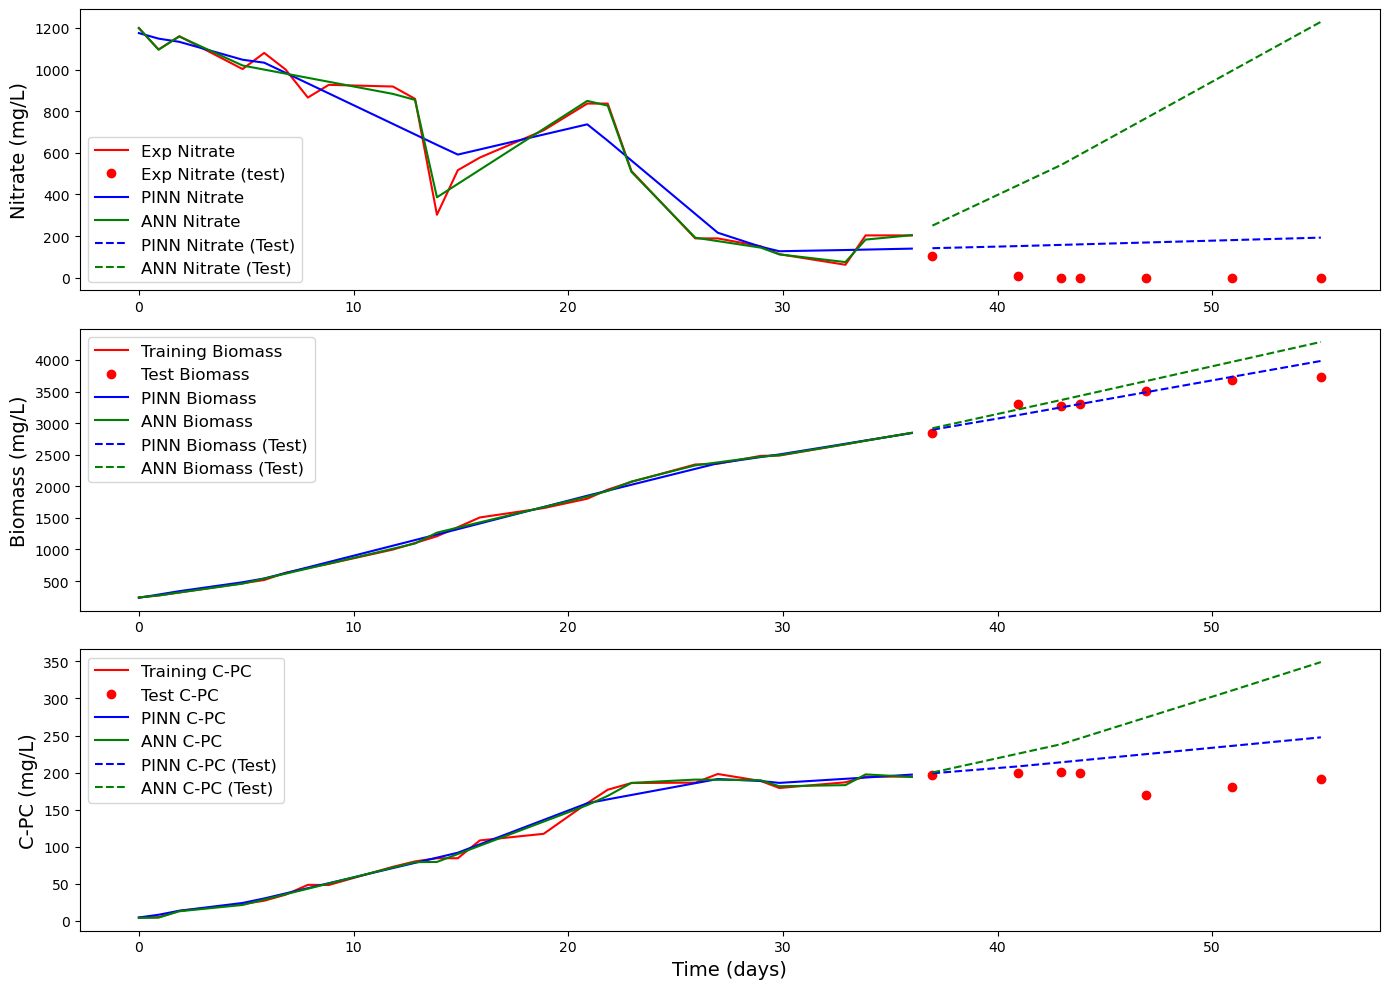

In [19]:
# Plot experimental vs predicted data for training and test sets
plt.figure(figsize=(14, 10))

# Plot Nitrate
plt.subplot(3, 1, 1)
plt.plot(t_train, data_train[:, 0], 'r-', label='Exp Nitrate')
plt.plot(t_test, data_test[:, 0], 'ro', label='Exp Nitrate (test)')
plt.plot(t_train, pinn_model(torch.tensor(t_train, dtype=torch.float32).view(-1, 1)).detach().numpy()[:, 0], 'b-', label='PINN Nitrate')
plt.plot(t_train, ann_model(torch.tensor(t_train, dtype=torch.float32).view(-1, 1)).detach().numpy()[:, 0], 'g-', label='ANN Nitrate')
plt.plot(t_test, predictions_pinn_test[:, 0], 'b--', label='PINN Nitrate (Test)')
plt.plot(t_test, predictions_ann_test[:, 0], 'g--', label='ANN Nitrate (Test)')
plt.ylabel('Nitrate (mg/L)', fontsize=14)
plt.legend(fontsize=12)

# Plot Biomass
plt.subplot(3, 1, 2)
plt.plot(t_train, data_train[:, 1], 'r-', label='Training Biomass')
plt.plot(t_test, data_test[:, 1], 'ro', label='Test Biomass')
plt.plot(t_train, pinn_model(torch.tensor(t_train, dtype=torch.float32).view(-1, 1)).detach().numpy()[:, 1], 'b-', label='PINN Biomass')
plt.plot(t_train, ann_model(torch.tensor(t_train, dtype=torch.float32).view(-1, 1)).detach().numpy()[:, 1], 'g-', label='ANN Biomass')
plt.plot(t_test, predictions_pinn_test[:, 1], 'b--', label='PINN Biomass (Test)')
plt.plot(t_test, predictions_ann_test[:, 1], 'g--', label='ANN Biomass (Test)')
plt.ylabel('Biomass (mg/L)', fontsize=14)
plt.legend(fontsize=12)

# Plot C-PC
plt.subplot(3, 1, 3)
plt.plot(t_train, data_train[:, 2], 'r-', label='Training C-PC')
plt.plot(t_test, data_test[:, 2], 'ro', label='Test C-PC')
plt.plot(t_train, pinn_model(torch.tensor(t_train, dtype=torch.float32).view(-1, 1)).detach().numpy()[:, 2], 'b-', label='PINN C-PC')
plt.plot(t_train, ann_model(torch.tensor(t_train, dtype=torch.float32).view(-1, 1)).detach().numpy()[:, 2], 'g-', label='ANN C-PC')
plt.plot(t_test, predictions_pinn_test[:, 2], 'b--', label='PINN C-PC (Test)')
plt.plot(t_test, predictions_ann_test[:, 2], 'g--', label='ANN C-PC (Test)')
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('C-PC (mg/L)', fontsize=14)
plt.legend(fontsize=12)

# Set tight layout and increase general font size
plt.tight_layout()
plt.show()

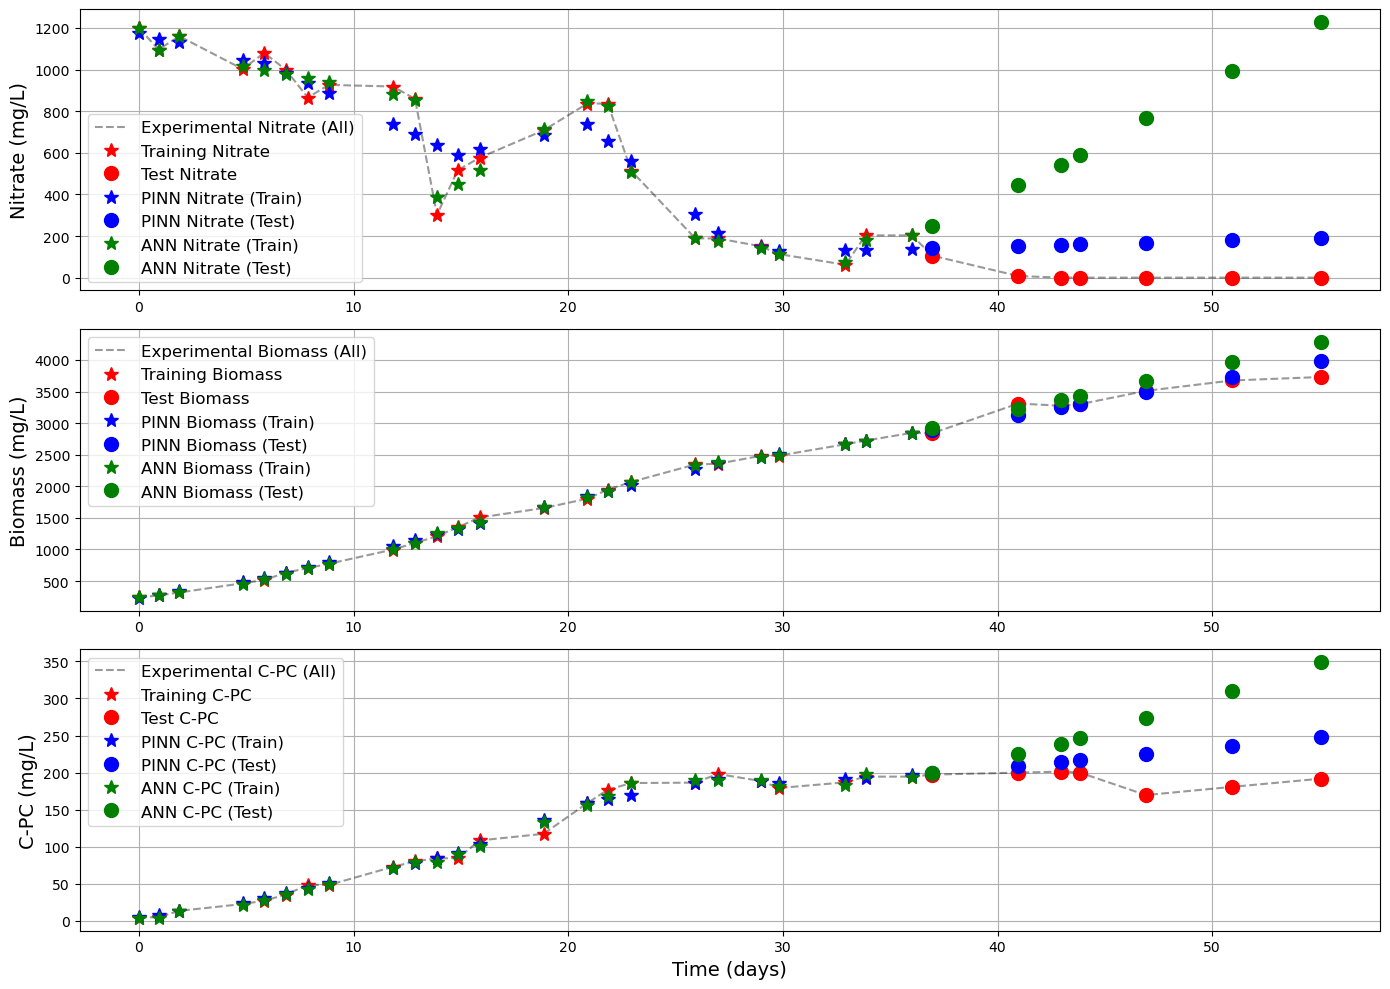

In [20]:
plt.figure(figsize=(14, 10))

# Overlay the full experimental dataset for reference
plt.subplot(3, 1, 1)
plt.plot(t_exp, data_exp[:, 0], 'k--', alpha=0.4, label='Experimental Nitrate (All)')

# Plot Training and Test Data
plt.plot(t_train, data_train[:, 0], 'r*', label='Training Nitrate', markersize=10)
plt.plot(t_test, data_test[:, 0], 'ro', label='Test Nitrate', markersize=10)

# Plot PINN Predictions
plt.plot(t_train, pinn_model(torch.tensor(t_train, dtype=torch.float32).view(-1, 1)).detach().numpy()[:, 0], 
         'b*', label='PINN Nitrate (Train)', markersize=10)
plt.plot(t_test, predictions_pinn_test[:, 0], 'bo', label='PINN Nitrate (Test)', markersize=10)

# Plot ANN Predictions
plt.plot(t_train, ann_model(torch.tensor(t_train, dtype=torch.float32).view(-1, 1)).detach().numpy()[:, 0], 
         'g*', label='ANN Nitrate (Train)', markersize=10)
plt.plot(t_test, predictions_ann_test[:, 0], 'go', label='ANN Nitrate (Test)', markersize=10)

# Set labels and legend
plt.ylabel('Nitrate (mg/L)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Repeat for Biomass
plt.subplot(3, 1, 2)
plt.plot(t_exp, data_exp[:, 1], 'k--', alpha=0.4, label='Experimental Biomass (All)')
plt.plot(t_train, data_train[:, 1], 'r*', label='Training Biomass', markersize=10)
plt.plot(t_test, data_test[:, 1], 'ro', label='Test Biomass', markersize=10)
plt.plot(t_train, pinn_model(torch.tensor(t_train, dtype=torch.float32).view(-1, 1)).detach().numpy()[:, 1], 
         'b*', label='PINN Biomass (Train)', markersize=10)
plt.plot(t_test, predictions_pinn_test[:, 1], 'bo', label='PINN Biomass (Test)', markersize=10)
plt.plot(t_train, ann_model(torch.tensor(t_train, dtype=torch.float32).view(-1, 1)).detach().numpy()[:, 1], 
         'g*', label='ANN Biomass (Train)', markersize=10)
plt.plot(t_test, predictions_ann_test[:, 1], 'go', label='ANN Biomass (Test)', markersize=10)
plt.ylabel('Biomass (mg/L)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Repeat for C-PC
plt.subplot(3, 1, 3)
plt.plot(t_exp, data_exp[:, 2], 'k--', alpha=0.4, label='Experimental C-PC (All)')
plt.plot(t_train, data_train[:, 2], 'r*', label='Training C-PC', markersize=10)
plt.plot(t_test, data_test[:, 2], 'ro', label='Test C-PC', markersize=10)
plt.plot(t_train, pinn_model(torch.tensor(t_train, dtype=torch.float32).view(-1, 1)).detach().numpy()[:, 2], 
         'b*', label='PINN C-PC (Train)', markersize=10)
plt.plot(t_test, predictions_pinn_test[:, 2], 'bo', label='PINN C-PC (Test)', markersize=10)
plt.plot(t_train, ann_model(torch.tensor(t_train, dtype=torch.float32).view(-1, 1)).detach().numpy()[:, 2], 
         'g*', label='ANN C-PC (Train)', markersize=10)
plt.plot(t_test, predictions_ann_test[:, 2], 'go', label='ANN C-PC (Test)', markersize=10)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('C-PC (mg/L)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Apply tight layout for better spacing
plt.tight_layout()
plt.show()

In [22]:
# Convert the experimental time data to a PyTorch tensor for prediction
t_exp_tensor = torch.tensor(t_exp, dtype=torch.float32).view(-1, 1)

# Calculate predictions from trained models
with torch.no_grad():
    predictions_pinn = pinn_model(t_exp_tensor).detach().numpy()
    predictions_ann = ann_model(t_exp_tensor).detach().numpy()

# Function to calculate MSE, RMSE, MAE, R² for each model
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2

# Convert the experimental data to numpy format for metric calculation
data_exp_tensor = np.array(data_exp)

# Calculate metrics for PINN
mse_pinn, rmse_pinn, mae_pinn, r2_pinn = calculate_metrics(data_exp_tensor, predictions_pinn)
# Calculate metrics for ANN
mse_ann, rmse_ann, mae_ann, r2_ann = calculate_metrics(data_exp_tensor, predictions_ann)

# Display the metrics
print("Performance Metrics for PINN:")
print(f"MSE: {mse_pinn:.4f}, RMSE: {rmse_pinn:.4f}, MAE: {mae_pinn:.4f}, R²: {r2_pinn:.4f}")

print("\nPerformance Metrics for ANN:")
print(f"MSE: {mse_ann:.4f}, RMSE: {rmse_ann:.4f}, MAE: {mae_ann:.4f}, R²: {r2_ann:.4f}")

Performance Metrics for PINN:
MSE: 6298.9951, RMSE: 79.3662, MAE: 47.5177, R²: 0.9497

Performance Metrics for ANN:
MSE: 48466.2192, RMSE: 220.1504, MAE: 81.8296, R²: 0.6357
